In [13]:
import numpy as np
import pandas as pd

In [14]:
#cluster visualization
#pull Z

Z = np.load("Z_latent.npy")  
df_best = pd.read_pickle("df_best.pkl")

In [15]:
#max k

max_k = df_best["Clusters"].max()


In [16]:
import matplotlib.pyplot as plt

base_cmap = plt.get_cmap("tab10")

cluster_colors = {
    cluster: base_cmap(cluster % 10)  
    for cluster in range(max_k)
}


In [17]:
from sklearn.manifold import TSNE

def plot_tsne_clusters_df_best(X, df_best, perplexity=30, random_state=42):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    X_tsne = tsne.fit_transform(X)

    for _, row in df_best.iterrows():

        k = row["Clusters"]
        labels = row["Labels"]  # use saved labels from df_best

        # fixed colors for each point
        point_colors = [cluster_colors[label] for label in labels]

        plt.figure(figsize=(8, 6))
        plt.title(f"t-SNE Visualization for Best Model (k={k}) - {row['Model']}", fontsize=14)

        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=point_colors, s=12)
        plt.xticks([])
        plt.yticks([])

        inertia_val = row.get("Inertia", None)
        inertia_str = "N/A" if inertia_val is None or (isinstance(inertia_val, float) and np.isnan(inertia_val)) else f"{inertia_val:.1f}"

        metrics_text = (
            f"Silhouette: {row['Silhouette']:.3f}\n"
            f"Davies-Bouldin: {row['DB']:.3f}\n"
            f"Calinski-Harabasz: {row['CH']:.1f}\n"
            f"Inertia: {inertia_str}\n"
            f"WeightedScore: {row['FinalScore']}\n"
            f"Params: {row['Params']}"
        )

        plt.text(
            0.02, 0.25, metrics_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.7)
        )

        plt.show()


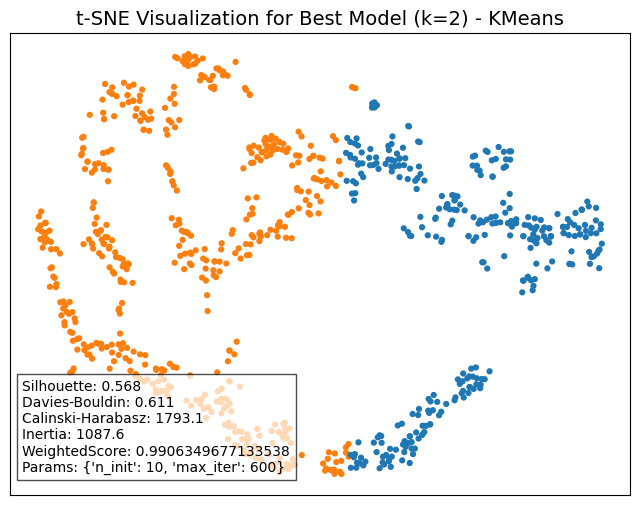

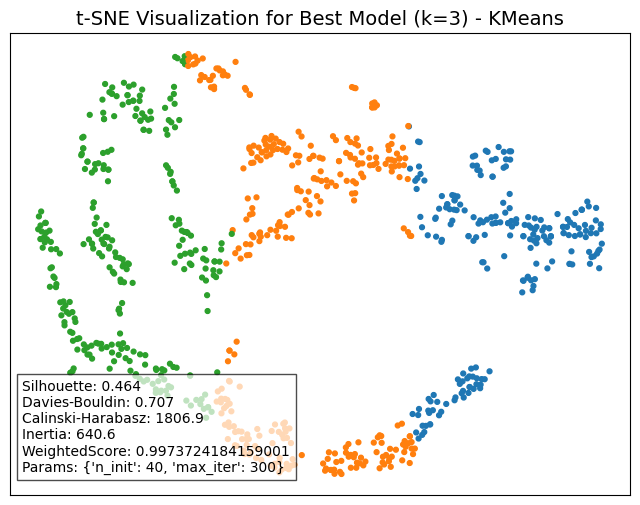

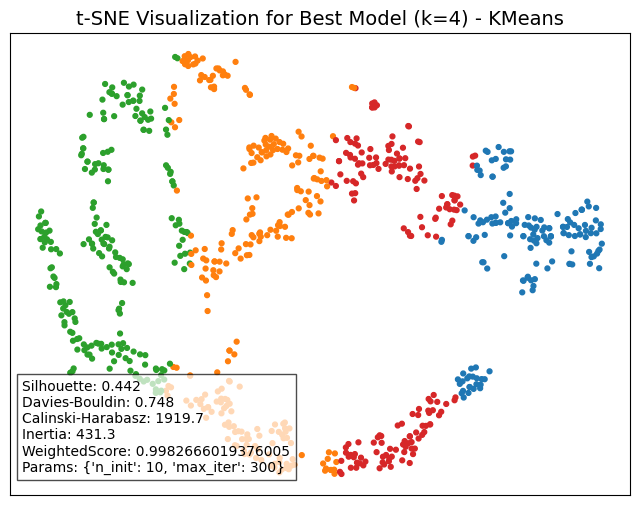

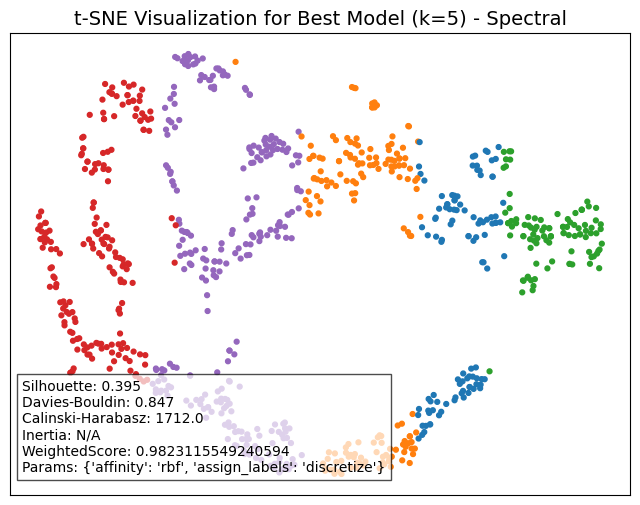

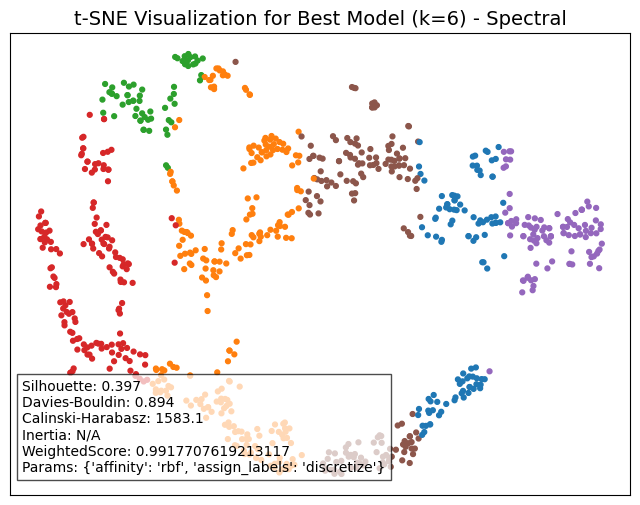

In [18]:
plot_tsne_clusters_df_best(Z,df_best)

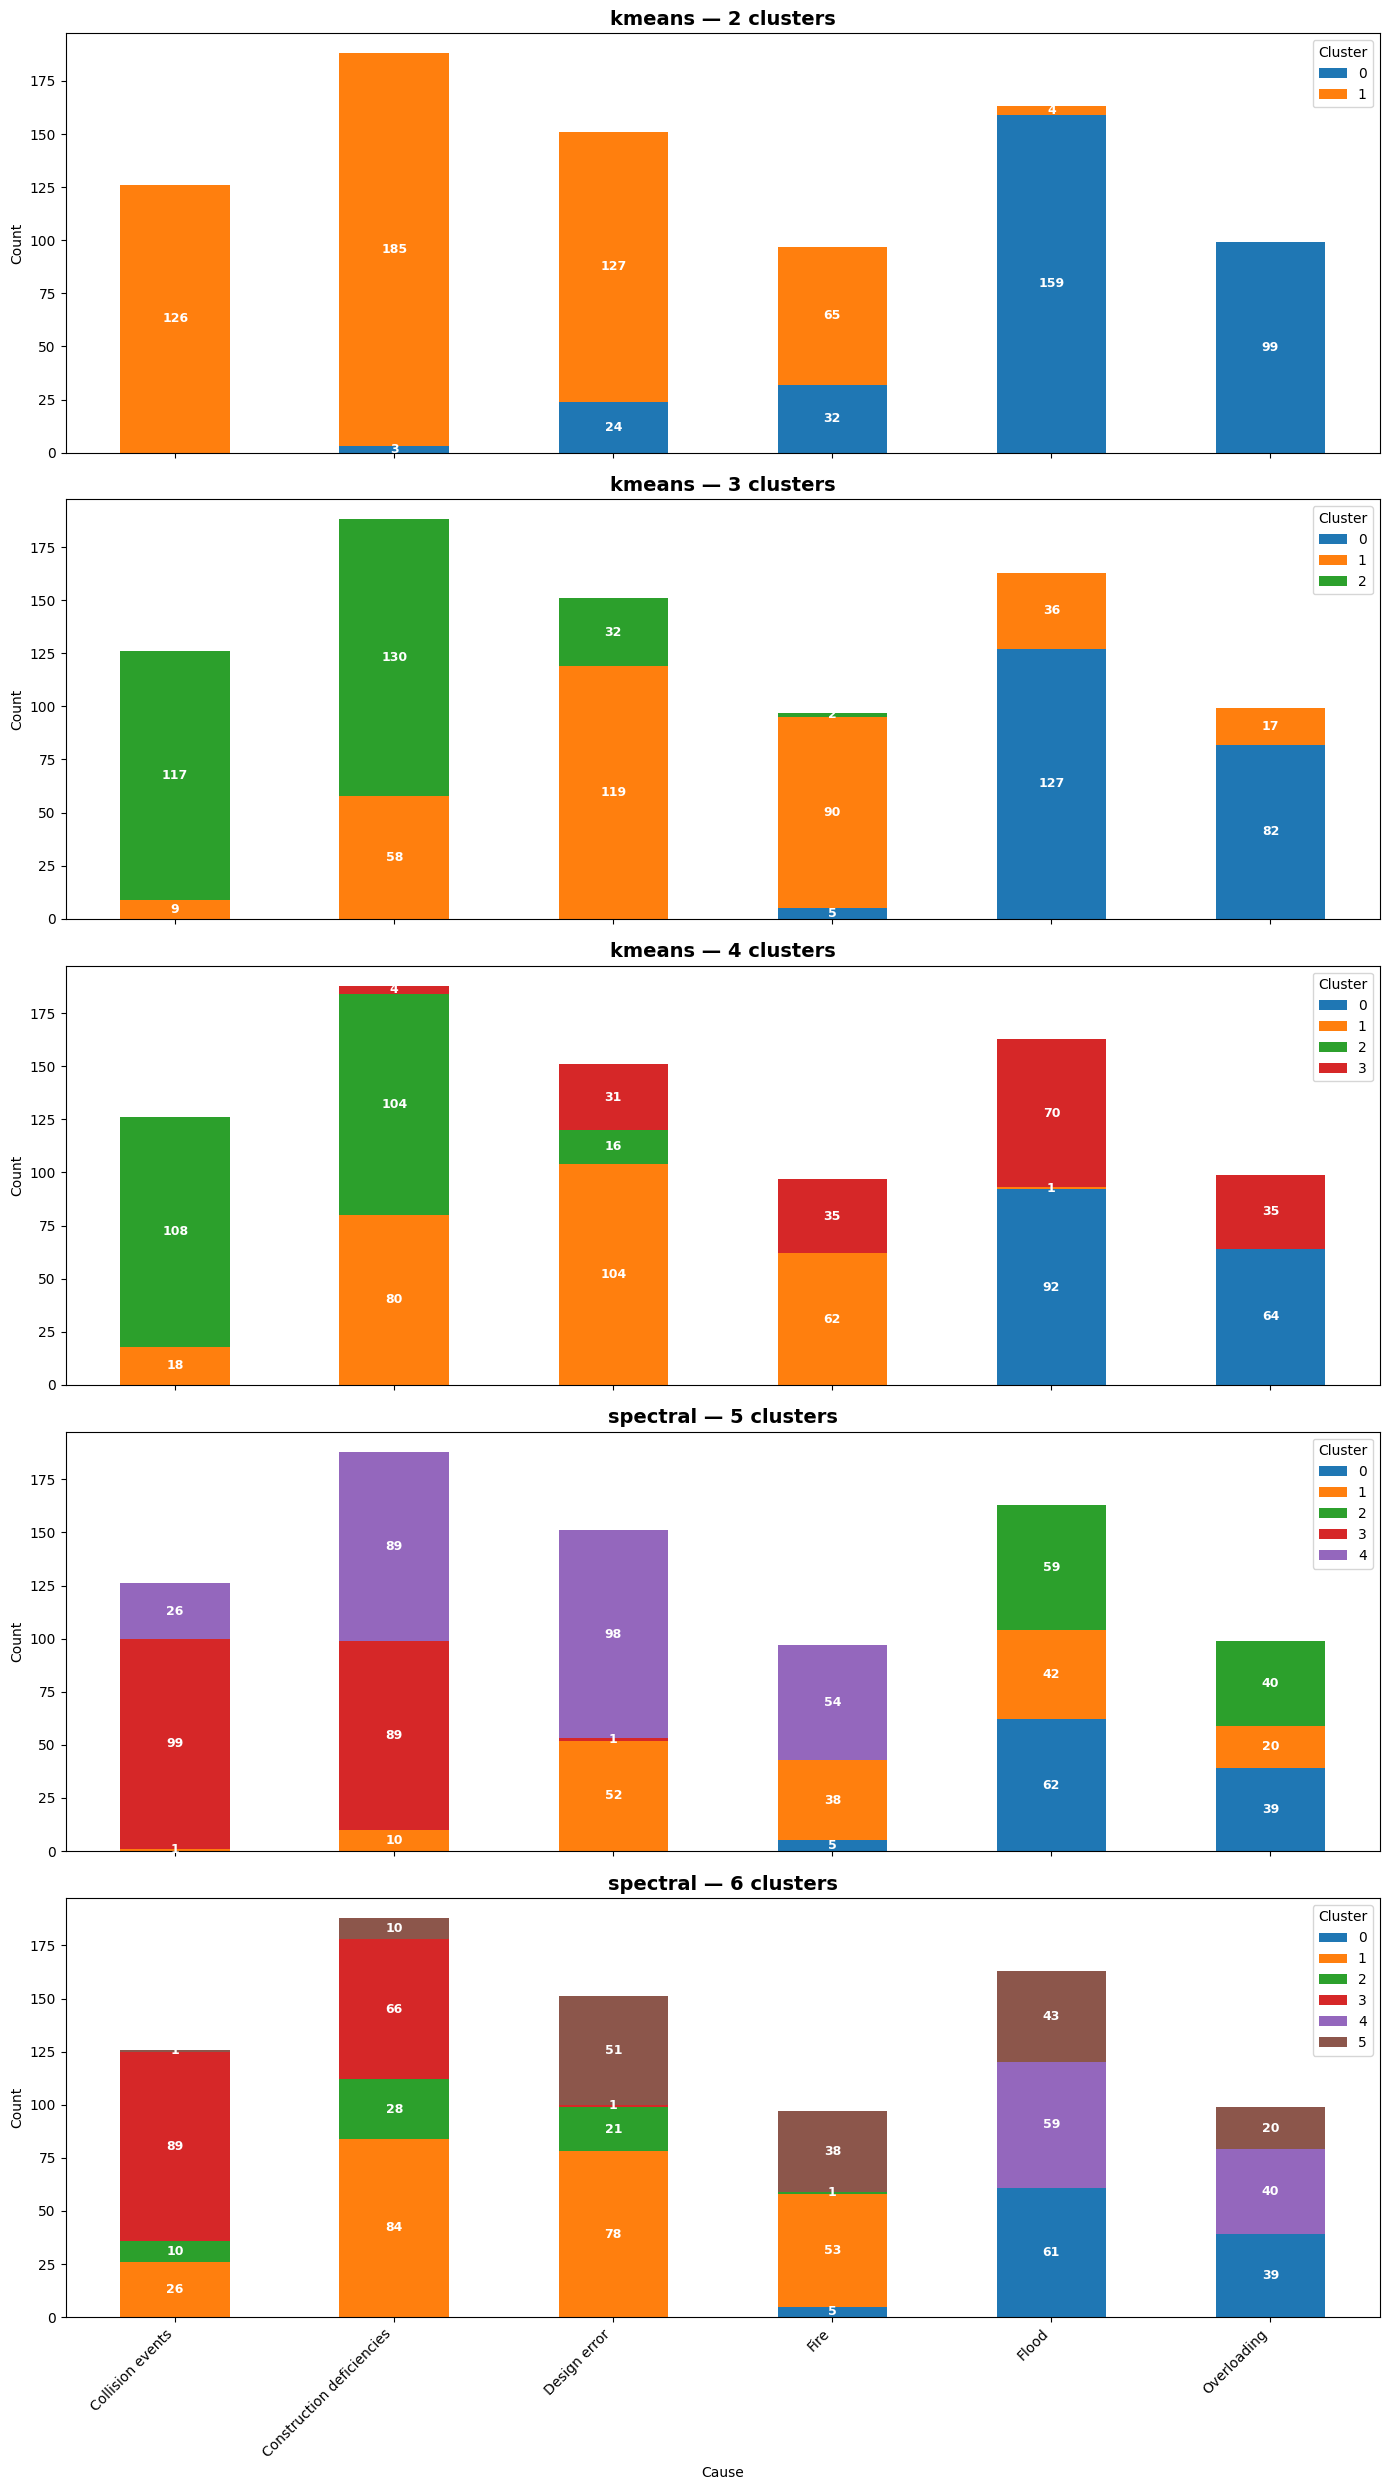

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Folder where you saved the CSVs
data_folder = r"E:\bridge_cause_analysis\Data\no_supervised_labeling"

max_k = df_best["Clusters"].max()
base_cmap = plt.get_cmap("tab10")

cluster_colors = {c: base_cmap(c % 10) for c in range(max_k)}

num_models = df_best.shape[0]
fig, axes = plt.subplots(num_models, 1, figsize=(14, 5 * num_models), sharex=True)

if num_models == 1:
    axes = [axes]  # ensure iterable

for i, ax in enumerate(axes):
    model_name = str(df_best.loc[i, "Model"]).lower()
    k = int(df_best.loc[i, "Clusters"])

    # Recover CSV
    filename = os.path.join(data_folder, f"{model_name}_k{k}.csv")
    model_df = pd.read_csv(filename)

    grouped = model_df.groupby(["Cause", "cluster"]).size().unstack(fill_value=0)

    # consistent color palette
    colors = [cluster_colors[c] for c in grouped.columns]

    # stacked bar chart
    grouped.plot(kind="bar", stacked=True, color=colors, ax=ax)

    # label counts
    for idx, cause in enumerate(grouped.index):
        y_offset = 0
        for cluster in grouped.columns:
            value = grouped.loc[cause, cluster]
            if value > 0:
                ax.text(
                    idx,
                    y_offset + value / 2,
                    str(value),
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="white",
                    fontweight="bold"
                )
            y_offset += value

    # title per subplot
    ax.set_title(
        f"{model_name} — {k} clusters",
        fontsize=14,
        fontweight="bold"
    )
    ax.set_ylabel("Count")
    ax.legend(title="Cluster", loc="upper right")

plt.xlabel("Cause")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os

data_folder = r"E:\bridge_cause_analysis\Data\no_supervised_labeling"

cluster_region_profiles = []

for i, file in enumerate(sorted(os.listdir(data_folder))):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(data_folder, file))

        df_counts = df.groupby(["cluster", "Region"]).size().reset_index(name="count")

        cluster_region_profiles.append({
            "model_index": i,
            "raw_counts": df_counts
        })


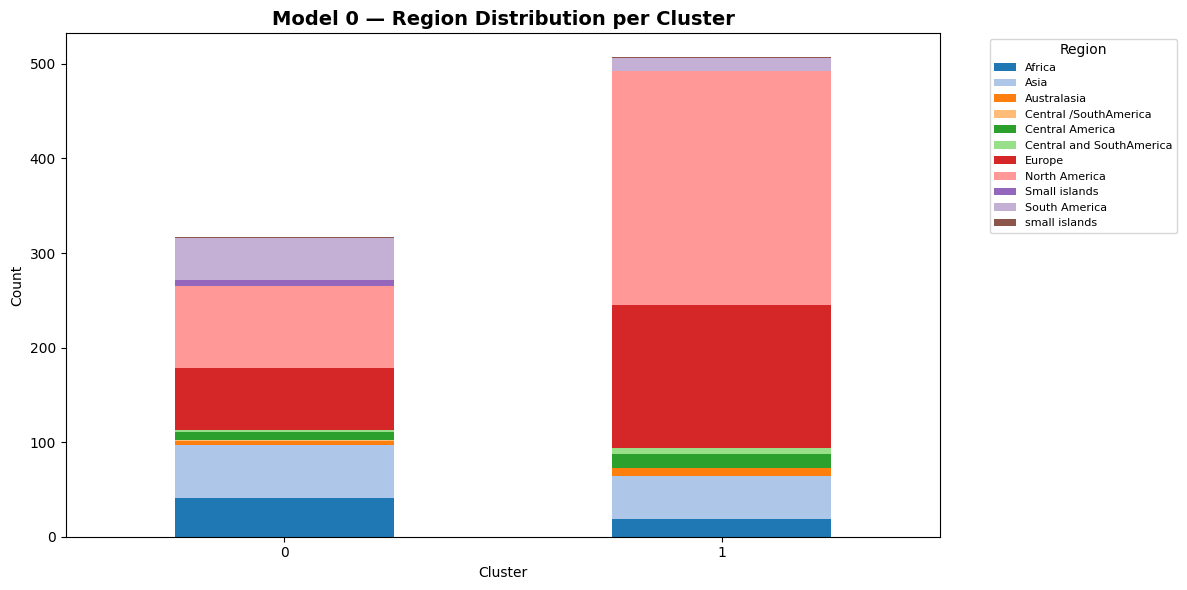

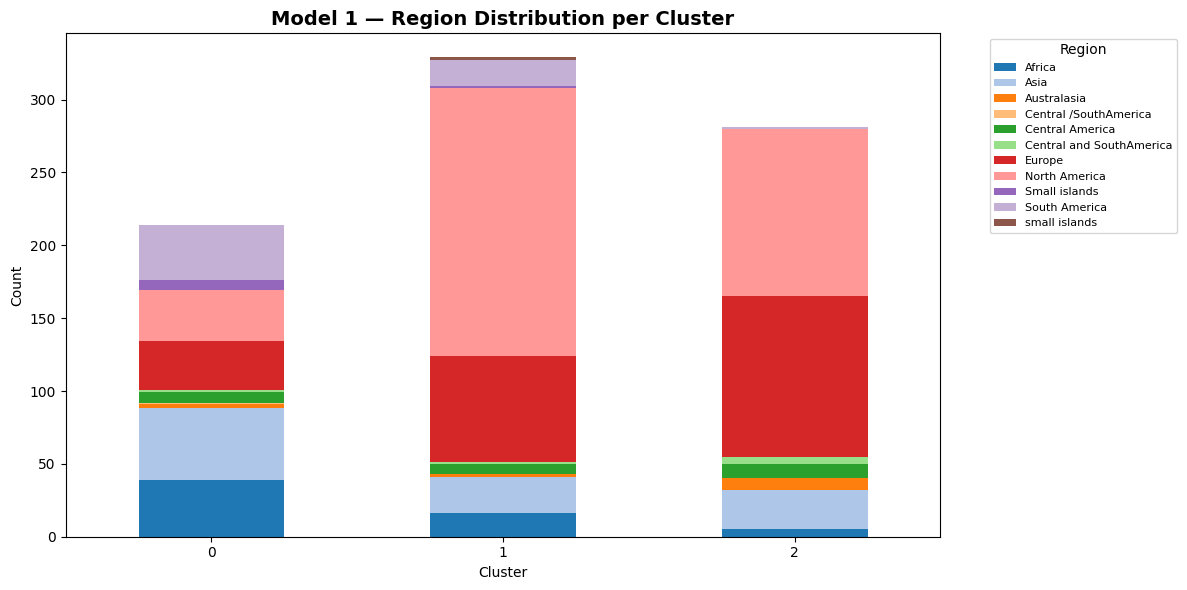

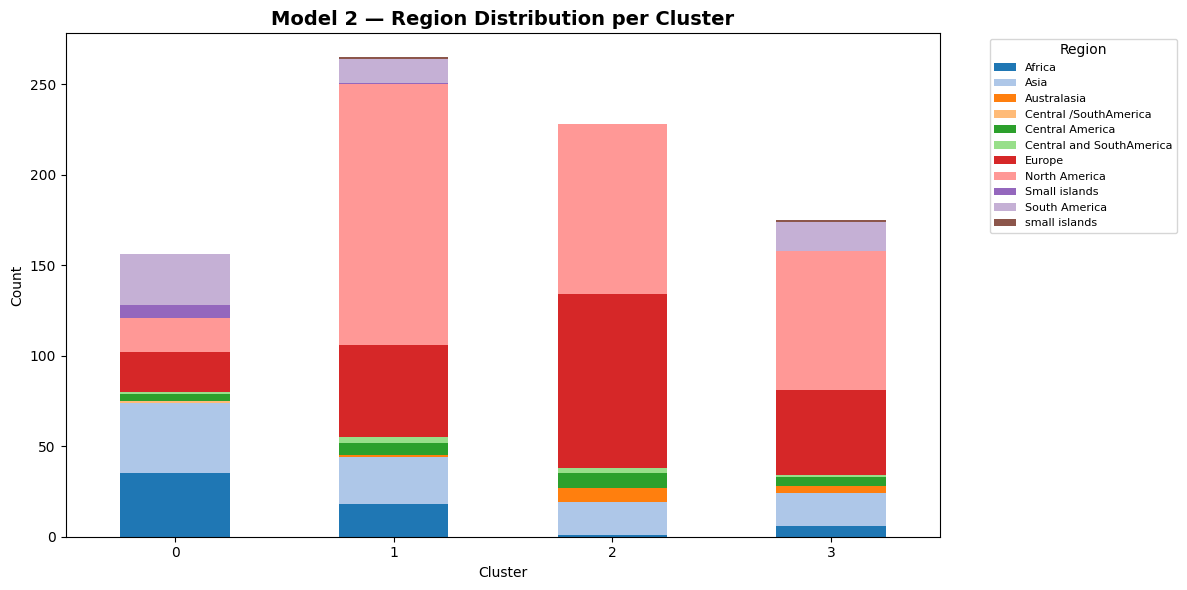

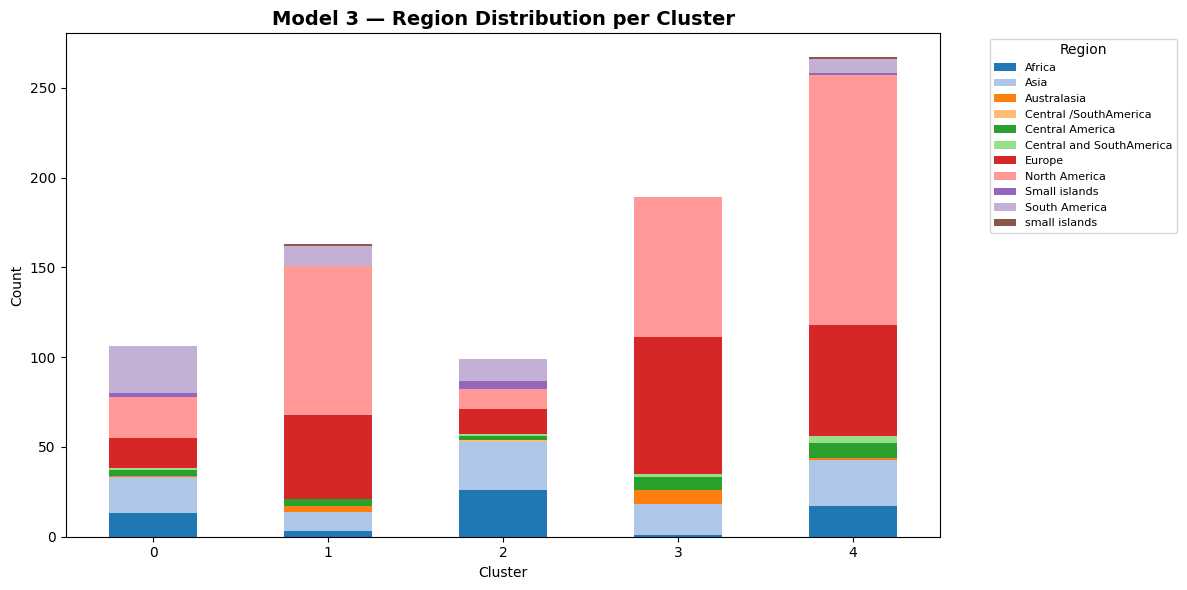

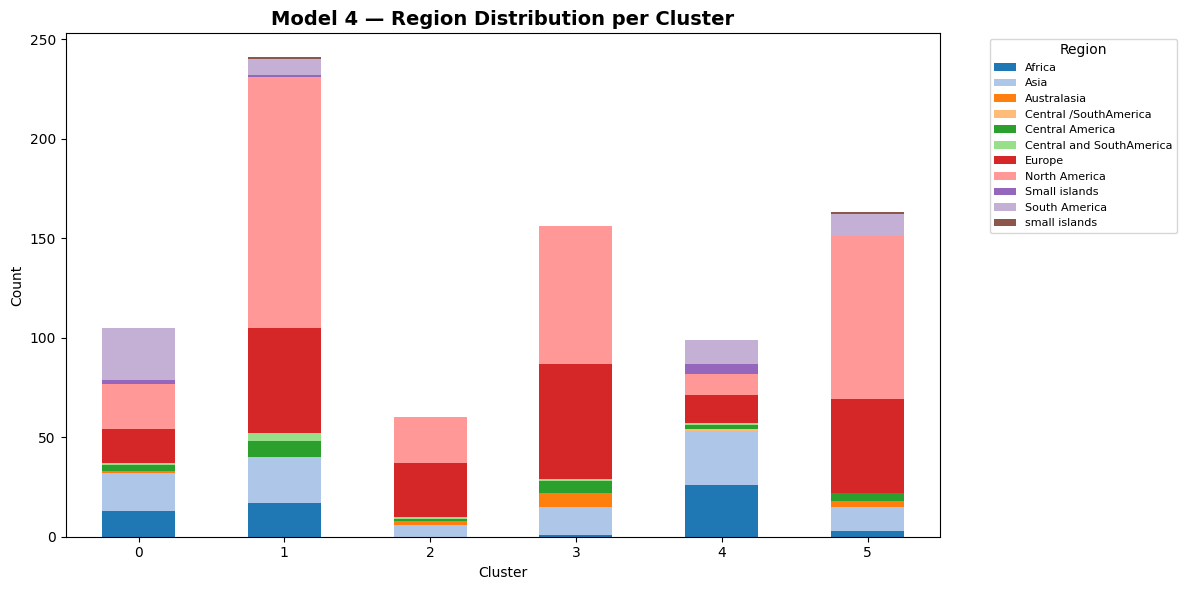

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Suppose cluster_region_profiles is a list of dicts like:
# cluster_region_profiles = [{"model_index": 0, "raw_counts": df_model0}, ...]

# Build a consistent color map for all regions
unique_regions = sorted(
    set(sum([list(profile["raw_counts"]["Region"].unique()) for profile in cluster_region_profiles], []))
)
palette = sns.color_palette("tab20", len(unique_regions))
color_map = {region: palette[i] for i, region in enumerate(unique_regions)}

for profile in cluster_region_profiles:

    model_index = profile["model_index"]
    df_counts = profile["raw_counts"]

    # Pivot table: clusters as rows, regions as columns
    pivot_df = df_counts.pivot(index="cluster", columns="Region", values="count").fillna(0)

    plt.figure(figsize=(12, 6))
    pivot_df.plot(
        kind="bar",
        stacked=True,
        color=[color_map[c] for c in pivot_df.columns],
        ax=plt.gca()
    )

    plt.title(f"Model {model_index} — Region Distribution per Cluster", fontsize=14, fontweight="bold")
    plt.xlabel("Cluster")
    plt.ylabel("Count")

    # Legend with smaller font
    plt.legend(
        title="Region",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=8
    )

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
